# Testing Kernel Density Estimation

## Simple Gaussian Curve

Generated 1000 samples using parameters [5. 1.]
Adding flat background of 10000.0 points


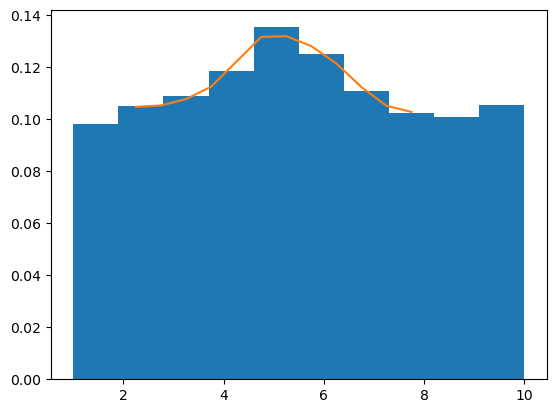

In [2]:
import emtk.curves
import emtk.omegaFunctions as omega
import numpy as np
import matplotlib.pyplot as plt

curv = emtk.curves.gaussianCurve()

sigma = 1.0
mu = 5.0
pvalues = np.array([mu, sigma])
xrange = np.array([1, 10])
curv.generateTestSamples(pvalues, xrange, 1000)
curv.generatebackground(xrange, 10.0)

#est = curv.kde(0.02)

fig,ax = plt.subplots()
hh=ax.hist(curv.data, density=True)
xgrid = np.arange(2, 8, 0.5)
#xgrid = hh[1]
xgrid = xgrid + 0.5*(xgrid[2]-xgrid[1])
yvals = curv.kde(xgrid)#kdeobject.evaluate(xgrid)
ax.plot(xgrid, yvals)

In [2]:
# The normalisation of the histogram and kde are "density" but we need to be careful
# Exactly what does that mean?  What is the normalisation factor?  Then we can use the
# density exactly as a probability to discard points in proportion to the background measurement.

# The hist density=True code is given here:
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html#matplotlib.pyplot.hist
# It's obvious from the curves above that the two codes are doing the same thing.

# If True, draw and return a probability density: each bin will display the bin's raw count 
# divided by the total number of counts and the bin width 

# (density = counts / (sum(counts) * np.diff(bins))), 

# so that the area under the histogram integrates to 1 

# (np.sum(density * np.diff(bins)) == 1).
# If stacked is also True, the sum of the histograms is normalized to 1.


print(np.sum(hh[0])*np.diff(hh[1]))
print(np.sum(yvals)*np.diff(xgrid))

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[0.70189443 0.70189443 0.70189443 0.70189443 0.70189443 0.70189443
 0.70189443 0.70189443 0.70189443 0.70189443 0.70189443]


This is no problem at all, looks good with both types of x-grid, *except* if you truncate the curve.

What is going on here, therefore, is that the KDE setup stage might represent a larger x-value area compared to the evaluation stage, and it is the **overlap of the setup and the evaluation that dictates the integral**.

## Lorentzian SANS Data

The following sets up a spectrum with an enormous flat background (10x measurement), and is working towards eventually subtracting that background by developing a KDE estimate that can be used to statistically reject data points in proportion to an arbitrary background curve.

Generated 100000 samples using parameters [0.01111111]
Adding flat background of 1000000.0 points


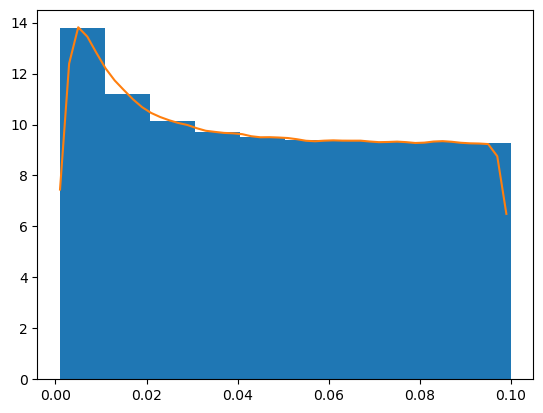

In [3]:
import emtk.curves
import numpy as np
import matplotlib.pyplot as plt


curv = emtk.curves.lorentzianCurve()

clength = 90.0 # correlation length in system
kappa = 1.0 / clength
pvalues = np.array([kappa])
xrange = np.array([0.001, 0.1])
curv.generateTestSamples(pvalues, xrange, 100000)
curv.generatebackground(xrange, 10.0)

est = curv.kde(0.02)

fig,ax = plt.subplots()
hh=ax.hist(curv.data, density=True)
xgrid = np.arange(xrange[0], xrange[1], 0.002)
#xgrid = hh[1]
#xgrid = xgrid + 0.5*(xgrid[2]-xgrid[1])
yvals = curv.kde(xgrid)#kdeobject.evaluate(xgrid)
ax.plot(xgrid, yvals)

In [4]:
print(np.sum(hh[0])*np.diff(hh[1]))
print(np.sum(yvals)*np.diff(xgrid))


[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[0.98806558 0.98806558 0.98806558 0.98806558 0.98806558 0.98806558
 0.98806558 0.98806558 0.98806558 0.98806558 0.98806558 0.98806558
 0.98806558 0.98806558 0.98806558 0.98806558 0.98806558 0.98806558
 0.98806558 0.98806558 0.98806558 0.98806558 0.98806558 0.98806558
 0.98806558 0.98806558 0.98806558 0.98806558 0.98806558 0.98806558
 0.98806558 0.98806558 0.98806558 0.98806558 0.98806558 0.98806558
 0.98806558 0.98806558 0.98806558 0.98806558 0.98806558 0.98806558
 0.98806558 0.98806558 0.98806558 0.98806558 0.98806558 0.98806558
 0.98806558]


Problem solved!  Now to use it to do background subtraction...

# Background Subtraction

## Gaussian

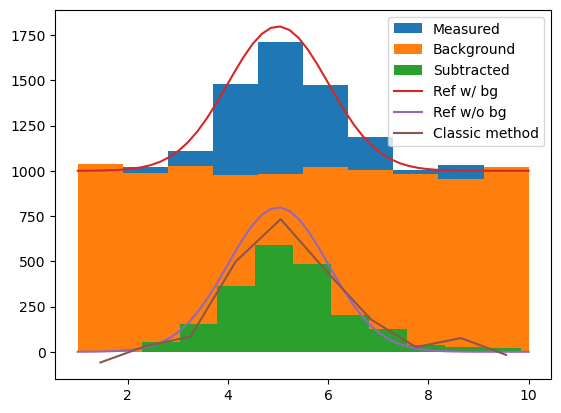

In [4]:
from scipy.stats import distributions

import numpy as np

import matplotlib.pyplot as plt

import emtk.curves
import emtk.omegaFunctions as omega

xrange = [1,10]
nevents= 2000
nbackground =10000

mu = 5.0
sigma = 1.0
xgrid = np.linspace(*xrange)

ref = distributions.norm(mu, sigma)
bg = distributions.uniform(loc=xrange[0], scale = xrange[1]-xrange[0])

signal = ref.rvs(nevents)
background = bg.rvs(nbackground)
independentbg = bg.rvs(nbackground)

signal = signal[(signal > xrange[0]) & (signal < xrange[1])]

measurement = np.concatenate((signal, background))
# must shuffle the points, otherwise the two things are anti-correlated
np.random.shuffle(measurement)


subtr = omega.kdeBackgroundSubtract(measurement, independentbg)

hm=plt.hist(measurement, label='Measured')
hh=plt.hist(independentbg, label='Background')

xctr = hh[1] + 0.5*np.diff(hh[1])[0]
xctr = np.delete(xctr, -1)
plt.hist(subtr, label='Subtracted')
plt.plot(xgrid, (signal.size * ref.pdf(xgrid) + np.mean(hh[0])), label='Ref w/ bg')
plt.plot(xgrid, signal.size * ref.pdf(xgrid), label='Ref w/o bg')

plt.plot(xctr, hm[0]-hh[0], label='Classic method')
plt.legend()

## A systematic Background

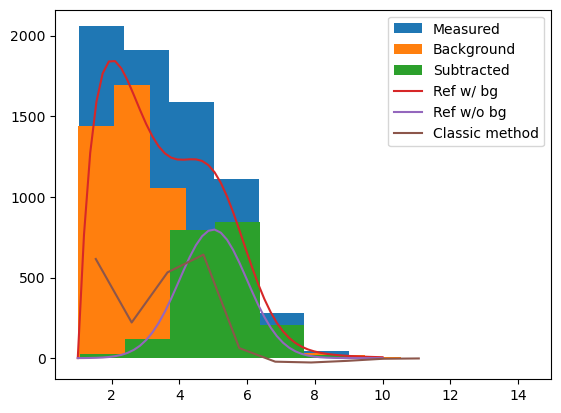

In [5]:
from scipy.stats import distributions

import numpy as np

import matplotlib.pyplot as plt

import emtk.curves
import emtk.omegaFunctions as omega

xrange = [1,10]
nevents= 2000
nbackground =5000

mu = 5.0
sigma = 1.0
xgrid = np.linspace(*xrange)

ref = distributions.norm(mu, sigma)
bg = distributions.erlang(a=2.0, loc=xrange[0], scale = 1.0)

signal = ref.rvs(nevents)
background = bg.rvs(nbackground)
independentbg = bg.rvs(nbackground)

signal = signal[(signal > xrange[0]) & (signal < xrange[1])]

measurement = np.concatenate((signal, background))
# must shuffle the points, otherwise the two things are anti-correlated
np.random.shuffle(measurement)


subtr = omega.kdeBackgroundSubtract(measurement, independentbg)

hm=plt.hist(measurement, label='Measured')
hh=plt.hist(independentbg, label='Background')

refw = nbackground * bg.pdf(xgrid) + nevents * ref.pdf(xgrid)

xctr = hh[1] + 0.5*np.diff(hh[1])[0]
xctr = np.delete(xctr, -1)
plt.hist(subtr, label='Subtracted')
plt.plot(xgrid, refw, label='Ref w/ bg')
plt.plot(xgrid, signal.size * ref.pdf(xgrid), label='Ref w/o bg')

plt.plot(xctr, hm[0]-hh[0], label='Classic method')
plt.legend()